In [1]:
import os
import numpy as np
import math 

import tensorflow as tf
from tensorflow import keras

from pathlib import Path
from IPython.display import display, Audio

import matplotlib.pyplot as plt
from pydub import AudioSegment

In [2]:
RAW_DATASET_PATH = os.path.join("..", "animal_sounds")
DATASET_AUDIO_PATH = os.path.join("..", "animal_sounds_clips")
# The sampling rate to use.
# This is the one used in all of the audio samples.
# This will also be the output size of the audio wave samples
# (since all samples are of 1 second long)
SAMPLING_RATE = 16000
# percentage of recordings used for validation
TEST_RATIO = 0.05
CLIP_LEN = 500

In [3]:
def prepare_data():
    if not os.path.exists(DATASET_AUDIO_PATH):
        os.makedirs(DATASET_AUDIO_PATH)

    for class_name in os.listdir(RAW_DATASET_PATH):
        before = 0
        after = 0
        files = os.listdir(os.path.join(RAW_DATASET_PATH, class_name))
        for file in files:
            if before < TEST_RATIO * len(files):
                target_path = os.path.join(DATASET_AUDIO_PATH, class_name[:-2]+"_valid")
            else:
                target_path = os.path.join(DATASET_AUDIO_PATH, class_name[:-2])
            if not os.path.exists(target_path):
                os.makedirs(target_path)
            p = os.path.join(RAW_DATASET_PATH, class_name, file)
            try:
                audio = AudioSegment.from_wav(p)
                audio = audio.set_frame_rate(SAMPLING_RATE)
            except:
                print(f"Could not load file {p}. Skipping.")
                continue
            before += 1
            step = math.floor(CLIP_LEN / 2.5) if class_name.startswith("kidney") or class_name.startswith("muscle") else CLIP_LEN // 2
            for t in range(3000, len(audio)-CLIP_LEN, step):
                after += 1
                new_audio = audio[t:t+CLIP_LEN]
                split = os.path.splitext(file)
                filename = split[0] + f"_{after}_{class_name}" + split[1]
                new_audio.export(os.path.join(target_path, filename),
                                format="wav", parameters=["-sample_fmt", "s16"])
        print(f"{class_name}: Split {before} tracks into {after} clips of length {CLIP_LEN/1000}s")

prepare_data()

Could not load file ..\animal_sounds\kidney_animal_1\REC67.WAV. Skipping.
kidney_animal_1: Split 45 tracks into 149 clips of length 0.5s
kidney_animal_2: Split 51 tracks into 276 clips of length 0.5s
liver_animal 2: Split 57 tracks into 629 clips of length 0.5s
Could not load file ..\animal_sounds\liver_animal_1\REC103.WAV. Skipping.
Could not load file ..\animal_sounds\liver_animal_1\REC107.WAV. Skipping.
liver_animal_1: Split 42 tracks into 268 clips of length 0.5s
Could not load file ..\animal_sounds\muscle_animal_1\REC77.WAV. Skipping.
muscle_animal_1: Split 46 tracks into 122 clips of length 0.5s
muscle_animal_2: Split 59 tracks into 268 clips of length 0.5s
ribs_animal_1: Split 53 tracks into 78 clips of length 0.5s
Could not load file ..\animal_sounds\ribs_animal_2\REC83.WAV. Skipping.
Could not load file ..\animal_sounds\ribs_animal_2\REC85.WAV. Skipping.
Could not load file ..\animal_sounds\ribs_animal_2\REC89.WAV. Skipping.
Could not load file ..\animal_sounds\ribs_animal_2\R

In [4]:
# Seed to use when shuffling the dataset and the noise
SHUFFLE_SEED = 5123

BATCH_SIZE = 128
EPOCHS = 100

In [5]:
def paths_and_labels_to_dataset(audio_paths, labels):
    """Constructs a dataset of audios and labels."""
    path_ds = tf.data.Dataset.from_tensor_slices(audio_paths)
    audio_ds = path_ds.map(lambda x: path_to_audio(x))
    label_ds = tf.data.Dataset.from_tensor_slices(labels)
    return tf.data.Dataset.zip((audio_ds, label_ds))


def path_to_audio(path):
    """Reads and decodes an audio file."""
    audio = tf.io.read_file(path)
    audio, _ = tf.audio.decode_wav(audio, 1, SAMPLING_RATE)
    return audio

def audio_to_fft(audio):
    # Since tf.signal.fft applies FFT on the innermost dimension,
    # we need to squeeze the dimensions and then expand them again
    # after FFT
    audio = tf.squeeze(audio, axis=-1)
    fft = tf.signal.fft(
        tf.cast(tf.complex(real=audio, imag=tf.zeros_like(audio)), tf.complex64)
    )
    fft = tf.expand_dims(fft, axis=-1)

    # Return the absolute value of the first half of the FFT
    # which represents the positive frequencies
    return tf.math.abs(fft[:, : (audio.shape[1] // 2), :])


# Get the list of audio file paths along with their corresponding labels

class_names = os.listdir(DATASET_AUDIO_PATH)
print("Our class names: {}".format(class_names,))

train_audio_paths = []
valid_audio_paths = []
train_labels = []
valid_labels = []
for label, name in enumerate(class_names):
    print("Processing material {}".format(name,))
    dir_path = Path(DATASET_AUDIO_PATH) / name
    speaker_sample_paths = [
        os.path.join(dir_path, filepath)
        for filepath in os.listdir(dir_path)
        if filepath.lower().endswith(".wav")
    ]
    label = label // 2 # coz every dir has a _valid copy
    if name.endswith("_valid"):
        valid_audio_paths += speaker_sample_paths
        valid_labels += [label] * len(speaker_sample_paths)
    else:
        train_audio_paths += speaker_sample_paths
        train_labels += [label] * len(speaker_sample_paths)
    print(f"Loaded {len(speaker_sample_paths)} files from class {label}.")
    
print(
    "Found {} files belonging to {} classes.".format(len(train_audio_paths) + len(valid_audio_paths), len(class_names)//2)
)

# Shuffle
rng = np.random.RandomState(SHUFFLE_SEED)
rng.shuffle(train_audio_paths)
rng = np.random.RandomState(SHUFFLE_SEED)
rng.shuffle(valid_audio_paths)
rng = np.random.RandomState(SHUFFLE_SEED)
rng.shuffle(train_labels)
rng = np.random.RandomState(SHUFFLE_SEED)
rng.shuffle(valid_labels)

print("Using {} files for training.".format(len(train_labels)))
print("Using {} files for validation.".format(len(valid_labels)))

# Create 2 datasets, one for training and the other for validation
train_ds = paths_and_labels_to_dataset(train_audio_paths, train_labels)
train_ds = train_ds.shuffle(buffer_size=BATCH_SIZE * 8, seed=SHUFFLE_SEED).batch(
    BATCH_SIZE
)

valid_ds = paths_and_labels_to_dataset(valid_audio_paths, valid_labels)
valid_ds = valid_ds.shuffle(buffer_size=32 * 8, seed=SHUFFLE_SEED).batch(32)

# Transform audio wave to the frequency domain using `audio_to_fft`
train_ds = train_ds.map(
    lambda x, y: (audio_to_fft(x), y), num_parallel_calls=tf.data.AUTOTUNE
)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

valid_ds = valid_ds.map(
    lambda x, y: (audio_to_fft(x), y), num_parallel_calls=tf.data.AUTOTUNE
)
valid_ds = valid_ds.prefetch(tf.data.AUTOTUNE)


Our class names: ['kidney_animal', 'kidney_animal_valid', 'liver_animal', 'liver_animal_valid', 'muscle_animal', 'muscle_animal_valid', 'ribs_animal', 'ribs_animal_valid', 'skin_animal', 'skin_animal_valid']
Processing material kidney_animal
Loaded 401 files from class 0.
Processing material kidney_animal_valid
Loaded 24 files from class 0.
Processing material liver_animal
Loaded 860 files from class 1.
Processing material liver_animal_valid
Loaded 37 files from class 1.
Processing material muscle_animal
Loaded 373 files from class 2.
Processing material muscle_animal_valid
Loaded 17 files from class 2.
Processing material ribs_animal
Loaded 437 files from class 3.
Processing material ribs_animal_valid
Loaded 15 files from class 3.
Processing material skin_animal
Loaded 868 files from class 4.
Processing material skin_animal_valid
Loaded 16 files from class 4.
Found 3048 files belonging to 5 classes.
Using 2939 files for training.
Using 109 files for validation.


In [6]:
def residual_block(x, filters, conv_num=3, activation="relu"):
    # Shortcut
    s = keras.layers.Conv1D(filters, 1, padding="same")(x)
    for i in range(conv_num - 1):
        x = keras.layers.Conv1D(filters, 3, padding="same")(x)
        x = keras.layers.Activation(activation)(x)
    x = keras.layers.Conv1D(filters, 3, padding="same")(x)
    x = keras.layers.Add()([x, s])
    x = keras.layers.Activation(activation)(x)
    return keras.layers.MaxPool1D(pool_size=2, strides=2)(x)


def build_model(input_shape, num_classes):
    inputs = keras.layers.Input(shape=input_shape, name="input")

    x = residual_block(inputs, 16, 2)
    x = residual_block(x, 32, 2)
    x = residual_block(x, 64, 3)
    x = residual_block(x, 128, 3)

    x = keras.layers.AveragePooling1D(pool_size=3, strides=3)(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(128, activation="relu")(x)

    outputs = keras.layers.Dense(num_classes, activation="softmax", name="output")(x)

    return keras.models.Model(inputs=inputs, outputs=outputs)


model = build_model((SAMPLING_RATE // 2, 1), len(class_names))

model.summary()

# Compile the model using Adam's default learning rate
model.compile(
    optimizer="Adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

# Add callbacks:
# 'EarlyStopping' to stop training when the model is not enhancing anymore
# 'ModelCheckPoint' to always keep the model that has the best val_accuracy
model_save_filename = "my_best_model.h5"

earlystopping_cb = keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)
mdlcheckpoint_cb = keras.callbacks.ModelCheckpoint(
    model_save_filename, monitor="val_accuracy", save_best_only=True
)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 8000, 1)]    0           []                               
                                                                                                  
 conv1d_1 (Conv1D)              (None, 8000, 16)     64          ['input[0][0]']                  
                                                                                                  
 activation (Activation)        (None, 8000, 16)     0           ['conv1d_1[0][0]']               
                                                                                                  
 conv1d_2 (Conv1D)              (None, 8000, 16)     784         ['activation[0][0]']             
                                                                                              

In [7]:
CHECKPOINT_PATH = Path("my_best_model.h5")
history = None
if os.path.exists(CHECKPOINT_PATH):
    model.load_weights(CHECKPOINT_PATH)
else:
    history = model.fit(
        train_ds,
        epochs=EPOCHS,
        validation_data=valid_ds,
        callbacks=[earlystopping_cb, mdlcheckpoint_cb],
)

Epoch 1/100
23/23 [==============================] - 55s 2s/step - loss: 9.7405 - accuracy: 0.2484 - val_loss: 1.7946 - val_accuracy: 0.1468
Epoch 2/100
23/23 [==============================] - 53s 2s/step - loss: 1.5339 - accuracy: 0.3382 - val_loss: 1.7599 - val_accuracy: 0.2661
Epoch 3/100
23/23 [==============================] - 50s 2s/step - loss: 1.4915 - accuracy: 0.3392 - val_loss: 1.7205 - val_accuracy: 0.2752
Epoch 4/100
23/23 [==============================] - 50s 2s/step - loss: 1.4585 - accuracy: 0.3556 - val_loss: 1.5245 - val_accuracy: 0.3761
Epoch 5/100
23/23 [==============================] - 50s 2s/step - loss: 1.3314 - accuracy: 0.4331 - val_loss: 1.5318 - val_accuracy: 0.3578
Epoch 6/100
23/23 [==============================] - 49s 2s/step - loss: 1.2380 - accuracy: 0.4617 - val_loss: 1.0420 - val_accuracy: 0.5413
Epoch 7/100
23/23 [==============================] - 46s 2s/step - loss: 1.1932 - accuracy: 0.5396 - val_loss: 1.1935 - val_accuracy: 0.5229
Epoch 8/100
2

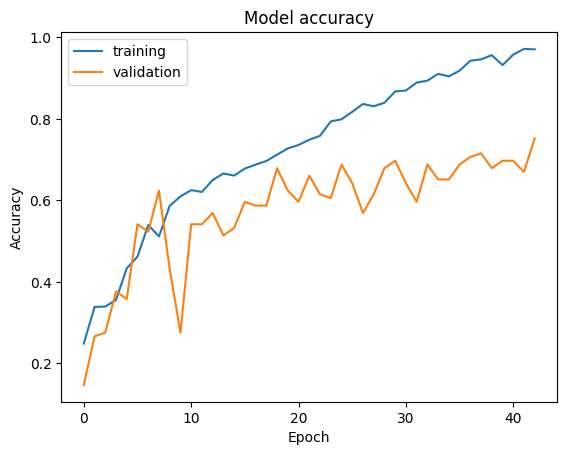

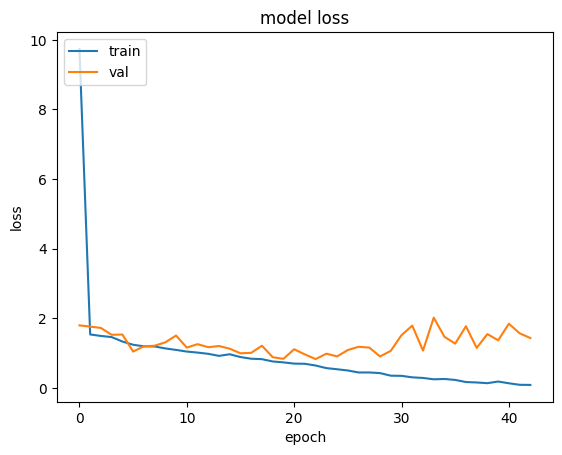

In [8]:
if history is not None:
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['training', 'validation'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

In [17]:
# SAMPLES_TO_DISPLAY = 5

# test_ds = paths_and_labels_to_dataset(train_audio_paths, train_labels)
# test_ds = test_ds.shuffle(buffer_size=BATCH_SIZE * 8, seed=SHUFFLE_SEED).batch(
#     BATCH_SIZE
# )
# for audios, labels in test_ds.take(1):
#     # Get the signal FFT
#     ffts = audio_to_fft(audios)
#     # Predict
#     y_pred = model.predict(ffts)
#     # Take random samples
#     rnd = np.random.randint(0, len(audios), SAMPLES_TO_DISPLAY)
#     audios = audios.numpy()[rnd, :, :]
#     labels = labels.numpy()[rnd]
#     y_pred = np.argmax(y_pred, axis=-1)[rnd]

#     for index in range(SAMPLES_TO_DISPLAY):
#         # For every sample, print the true and predicted label
#         # as well as run the voice with the noise
#         print(
#             "Speaker: {} - Predicted: {}".format(
#                 class_names[labels[index]],
#                 class_names[y_pred[index]],
#             )
#         )
#         display(Audio(audios[index, :, :].squeeze(), rate=SAMPLING_RATE))

In [9]:
test_ds = paths_and_labels_to_dataset(train_audio_paths + valid_audio_paths, train_labels + valid_labels)
test_ds = test_ds.shuffle(buffer_size=BATCH_SIZE * 8, seed=SHUFFLE_SEED).batch(
    BATCH_SIZE
)

actual_class_names = [n for n in class_names if not n.endswith("_valid")]

confusion = np.zeros((len(actual_class_names),)*2, dtype=np.float32)
counter = 0
for audios, labels in test_ds.take(1000):
    # Get the signal FFT
    ffts = audio_to_fft(audios)
    # Predict
    y_pred = model.predict(ffts)
    y_pred = np.argmax(y_pred, axis=-1)
    for idx, pred in enumerate(y_pred):
        counter += 1
        confusion[labels[idx], pred] += 1

print(counter)


for idx, label in enumerate(actual_class_names):
    confusion[idx, :] /= np.sum(confusion[idx, :])
    print(f"{idx} - {label}")

4/4 [==============================] - 1s 84ms/step
3048
0 - kidney_animal
1 - liver_animal
2 - muscle_animal
3 - ribs_animal
4 - skin_animal


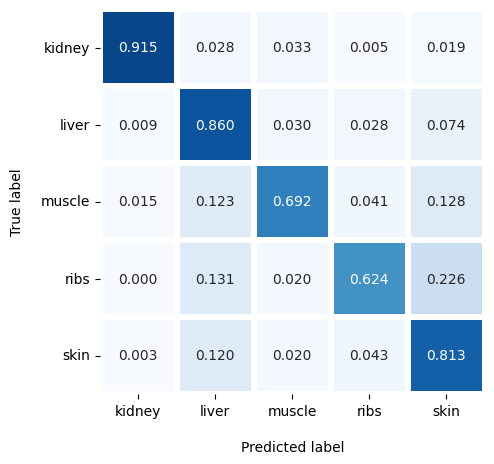

In [10]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
labels = [x.split("_")[0] for x in actual_class_names]
# labels = ["ribs", "kidney", "liver", "muscle", "skin"]
df_cm = pd.DataFrame(confusion, index=labels, columns=labels)
plt.figure(figsize=(7, 5))
sn.heatmap(df_cm, annot=True, fmt=".3f", square=True, cbar=False, cmap="Blues", linewidths=3, vmin=0, vmax=1)
plt.xlabel("Predicted label", labelpad=16)
plt.ylabel("True label", labelpad=12)
plt.tick_params(axis='y', rotation=0)
plt.show()